<a href="https://colab.research.google.com/github/a22106/ImageClassification/blob/main/ComputerVision/FashionMNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import PIL
import numpy as np
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn

print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [2]:
device = 'cuda' 

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, resample = PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1293: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [4]:
# Load our Train Data and specify what transform to use when loading
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])

# Prepare train and test loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### **Adding Dropout**

CNN에서 Dropout은 Conv -> ReLU 층 다음에 

E.g. CONV->RELU->**DROPOUT**

#### **Dropout Recommendations** 

In CNN's values of 0.1 to 0.3 have been found to work well.

### **Adding BatchNorm**

In CNNs **BatchNorm** is best used between the Conv Layer and the activation function layer (ReLU)
When used with Dropout, the recommended order is: 

CONV_1 -> **BatchNorm** -> ReLU -> Dropout - CONV_2

**NOTE** BatchNorm's input arguement is the **output** size of the previous layer.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Adding BatchNorm, using 32 as the input since 32 was the output of our first Conv layer
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Adding BatchNorm, using 64 as the input since 64 was the output of our first Conv layer
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        # Defining our dropout function with a rate of 0.2
        # We can apply this after any layer, but it's best suited after ReLU
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))

        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [6]:
# We import our optimizer function
import torch.optim as optim

# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

In [7]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 15

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accurachy
        running_loss += loss.item()
        if i % 100 == 99:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in testloader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value
                    _, predicted = torch.max(outputs.data, 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.377, Test Accuracy = 70.850%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.637, Test Accuracy = 75.190%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.541, Test Accuracy = 76.240%
Epoch: 1, Mini-Batches Completed: 400, Loss: 1.417, Test Accuracy = 76.320%
Epoch: 1, Mini-Batches Completed: 500, Loss: 1.351, Test Accuracy = 76.740%
Epoch: 1, Mini-Batches Completed: 600, Loss: 1.299, Test Accuracy = 78.970%
Epoch: 1, Mini-Batches Completed: 700, Loss: 1.292, Test Accuracy = 79.520%
Epoch: 1, Mini-Batches Completed: 800, Loss: 1.230, Test Accuracy = 78.810%
Epoch: 1, Mini-Batches Completed: 900, Loss: 1.268, Test Accuracy = 76.430%
Epoch: 1, Mini-Batches Completed: 1000, Loss: 1.182, Test Accuracy = 80.150%
Epoch: 1, Mini-Batches Completed: 1100, Loss: 1.136, Test Accuracy = 80.250%
Epoch: 1, Mini-Batches Completed: 1200, Loss: 1.139, Test Accuracy = 79.610%
Epoch: 1, Mini-Batches Completed: 1300, Loss: 1.145, Test Accura

In [8]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 89.07%


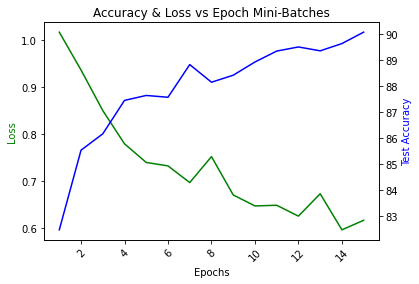

In [9]:
import matplotlib.pyplot as plt

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()